In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, stats, optimize

x_file = './roboao_tt/lx_all_library.txt'
y_file = './roboao_tt/ly_all_library.txt'
x_tt, y_tt = (np.genfromtxt(file).flatten() * 0.0175797 * 2 for file in (x_file, y_file))

In [2]:
f_sampling = 8.6
filter_N = 500
lim = 1000

(1e-07, 537.5340593347228)

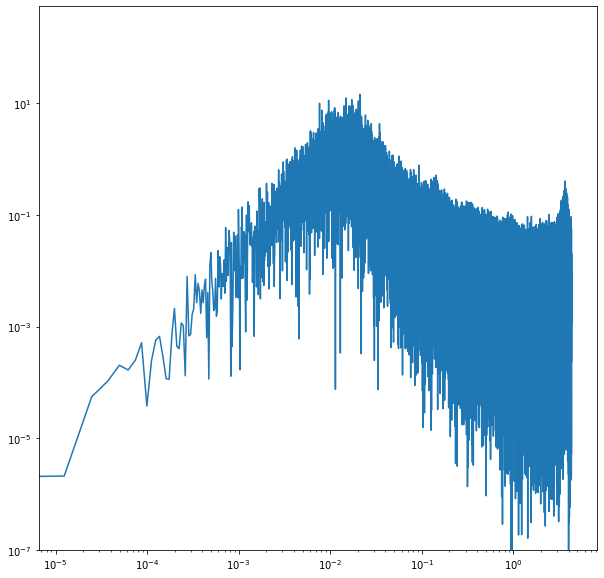

In [3]:
f, Pxx = signal.periodogram(x_tt, fs=f_sampling)
plt.figure(figsize=(10,10))
plt.loglog(f, Pxx)
plt.ylim(1e-7)

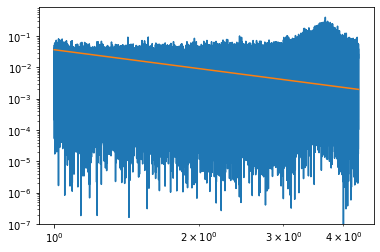

In [4]:
fsq = np.where(f >= 1)
plt.loglog(f[fsq], Pxx[fsq])
plt.ylim(1e-7)
model_sq = np.vectorize(lambda logf, a: -2 * logf + a)
asq = optimize.curve_fit(model_sq, np.log(f[fsq]), np.log(Pxx[fsq]), [1])[0]
plt.loglog(f[fsq], np.e**model_sq(np.log(f[fsq]), asq))
plt.show()

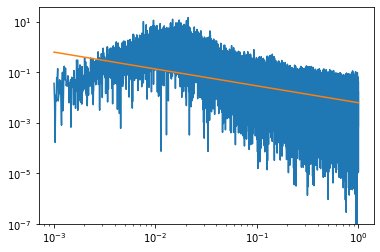

In [5]:
f23 = np.where(np.logical_and(f > 1e-3, f <= 1))
plt.loglog(f[f23], Pxx[f23])
plt.ylim(1e-7)
model_23 = np.vectorize(lambda logf, a: (-2/3) * logf + a)
a23 = optimize.curve_fit(model_23, np.log(f[f23]), np.log(Pxx[f23]), [1])[0]
plt.loglog(f[f23], np.e**model_23(np.log(f[f23]), a23))
plt.show()

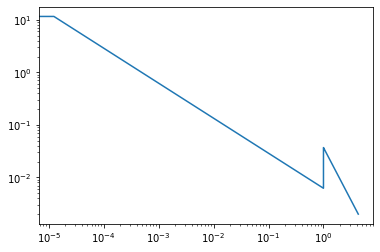

In [6]:
def model(freq):
    if freq == 0:
        return model(f[1])
    elif freq <= 1:
        return np.e**((-2/3) * np.log(freq) + a23)
    return np.e**((-2) * np.log(freq) + asq)

model = np.vectorize(model)

plt.loglog(f, model(f))

In [7]:
from fractal_deriv import *

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/adityasengupta/projects/adaptive-optics/control/dev/fractal_deriv.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  y[k] = np.sum(u[range(k,k-L,-1)]*a[0:L])


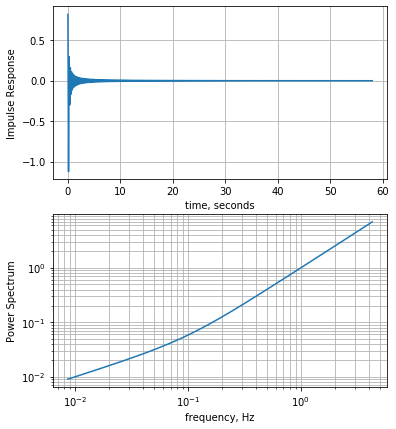

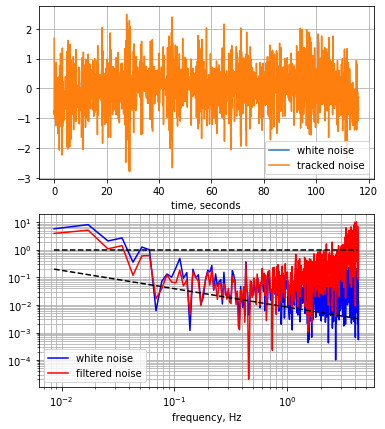

In [8]:
filter_turbulence = design_filt(dt = 1/f_sampling, N = 2*filter_N) 
# the good thing about Robo-AO frequency being so low 
# is I can drive N really low and match it
response = filt(filter_turbulence, dt=1/f_sampling, u=x_tt[:lim])
# I'm worried about overfitting right now, but let's try and ignore that and instead just translate this to SS

In [9]:
def make_impulse_filter(x):
    # takes in np array x: the impulse response of a filter
    # returns matrices A, P, Q, H, R to augment with the kfilter
    n = x.size
    # basically the idea is to drive the Kalman filter's physics model with a Wiener/convolution filter.
    A = np.zeros((n, n))
    for i in range(1, n):
        A[i][i-1] = 1
    A[0] = np.flip(x)
    # when you start the filter, make sure to start it at time n with the first n measurements identically
    # P is just zeros and it'll get tuned online
    P = np.zeros((n,n))
    Q = np.zeros((n,n))
    Q[0][0] = 1e-3 # completely arbitrary
    H = np.zeros((1,n))
    H[:,0] = 1
    R = np.array([0.06])
    return A, P, Q, H, R

A, P, Q, H, R = make_impulse_filter(filter_turbulence)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


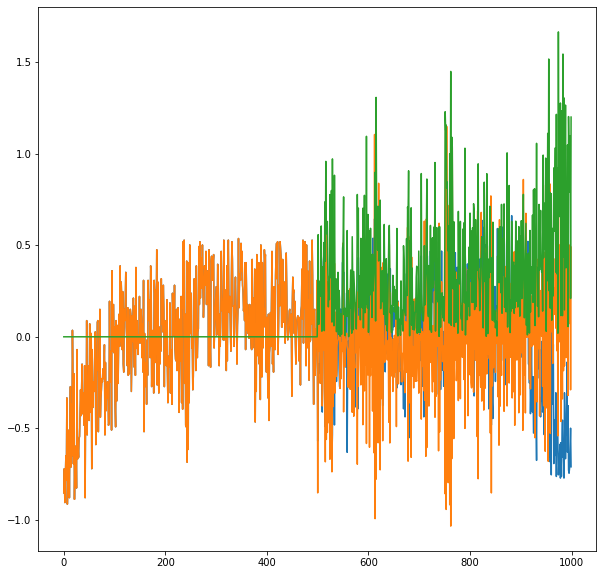

In [10]:
# now, let's filter with this
state = x_tt[:filter_N]
predictions = np.zeros(lim,)
predictions[:filter_N] = x_tt[:filter_N]
for i, measurement in enumerate(x_tt[filter_N:lim]):
    predictions[i + filter_N] = H.dot(state)
    state = A.dot(state)
    
plt.figure(figsize=(10,10))
plt.plot(x_tt[:lim])
plt.plot(predictions[:lim])
plt.plot(np.abs(x_tt[:lim] - predictions[:lim]))

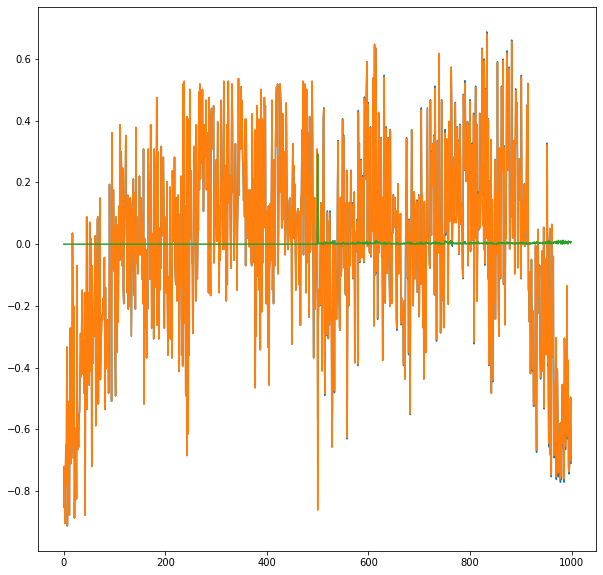

In [41]:
# now, let's Kalman filter with this
# I have high expectations of this and if they are not met I will be very very sad

from observer import kfilter
kfiltered = kfilter((measurements[:filter_N], A, P, Q * 200, H, R), x_tt[filter_N:lim])
plt.figure(figsize=(10,10))
plt.plot(x_tt[:lim])
plt.plot(np.hstack((x_tt[:filter_N], kfiltered)))
plt.plot(np.abs(x_tt[:lim] - np.hstack((x_tt[:filter_N], kfiltered))))

In [23]:
# let's calculate the measurement error 
zeropoint = 452 * 1.51 * 10**7 # photons/s/m^2
throughput = 0.5
wavelength = 806e-9 # m
diameter = 2.1 # m
Hmag = 9.0    # star's H magnitude

## Compute measurement noise
photons_per_measurement       = zeropoint * 10**(-0.4*Hmag) * (1.0/f_sampling) * (np.pi * (diameter/2)**2) * throughput
measurement_noise_single_axis = wavelength/(np.pi * diameter * np.sqrt(photons_per_measurement)) * 206265 # arcseconds
print('Single axis measurement noise = ', round(measurement_noise_single_axis*1000,2), ' mas')

Single axis measurement noise =  0.04  mas


In [25]:
true_tts = x_tt[:lim]
measurements = true_tts + np.random.normal(0, 0.04, true_tts.shape)

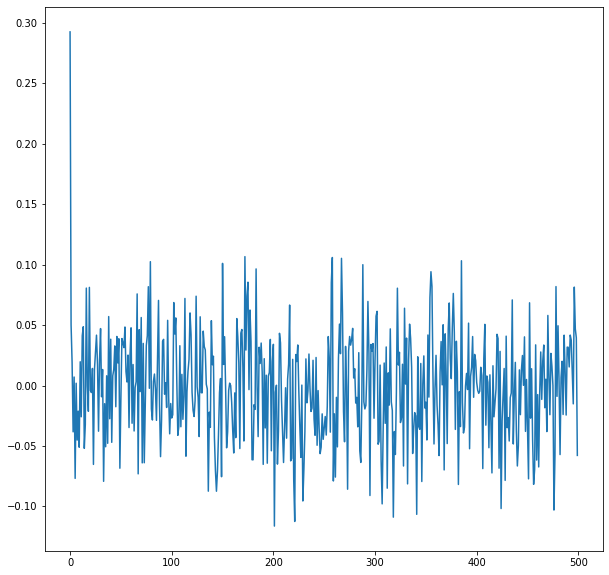

In [40]:
R = np.array([0.04**2])
rms = lambda data: np.sqrt(np.mean(data ** 2))
kfiltered_q = lambda q: kfilter((measurements[:filter_N], A, P, Q * 1000 * q, H, R), measurements[filter_N:lim])
'''
def to_optimize(q):
    print(q)
    error = rms(kfiltered_q(q) - true_tts[filter_N:lim])
    print(error)
    return error

res = optimize.minimize(to_optimize, [1])
print(res)'''
    
plt.figure(figsize=(10,10))
plt.plot(true_tts[filter_N:lim] - kfiltered_q(6.66982581))

Okay, this is bad - seems like the Kalman filter can't actually get rid of any of the measurement noise.